## ✅ Step 1: Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


## ✅ Step 2: Load Labels and Prepare Image Pairs

In [2]:
excel_path = 'all_timeslot_cleaned.csv'  # 🔁 Replace with your Excel file path
image_folder = 'all_images'     # 🔁 Replace with your image folder path

df = pd.read_csv(excel_path)
image_names = df['Filename'].tolist()
# labels = df.iloc[:, 1:8].values  # Assumes columns 1 onward are 7 pollutant values
# Select specific pollutant columns by name
labels = df[['CO', 'NO2', 'PM25', 'PM10', 'O3']].values


prototype_idx = 0
prototype_name = image_names[prototype_idx]
prototype_label = labels[prototype_idx]
pairs = [(prototype_name, name) for i, name in enumerate(image_names) if i != prototype_idx]
print(f'Prototype image name: {prototype_name} | Prototype label: {prototype_label}' )

Prototype image name: image202505280271.jpg | Prototype label: [  1.474  20.     19.     26.    148.   ]


## ✅ Step 3: Split into Train and Validation Sets

In [3]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42)

# Print the lengths
print(f"Length of train_pairs: {len(train_pairs)}")
print(f"Length of val_pairs: {len(val_pairs)}")


Length of train_pairs: 18549
Length of val_pairs: 2062


## ✅ Step 4: Define Dataset Class

In [4]:
class AirPollutionPairDataset(Dataset):
    def __init__(self, pairs, labels, image_folder, transform=None):
        self.pairs = pairs
        self.labels = labels  # Assuming labels is a list/array where index matches image_names
        self.image_folder = image_folder
        self.transform = transform
        # Added: Store image names as an instance variable to avoid global dependency
        self.image_names = image_names  # Make sure this is properly initialized

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        proto_name, query_name = self.pairs[idx]
        proto_idx = self.image_names.index(proto_name)  # Use self.image_names instead of global
        query_idx = self.image_names.index(query_name)

        proto_img = Image.open(os.path.join(self.image_folder, proto_name)).convert('RGB')
        query_img = Image.open(os.path.join(self.image_folder, query_name)).convert('RGB')

        if self.transform:
            proto_img = self.transform(proto_img)
            query_img = self.transform(query_img)

        # Extract the individual labels
        proto_label = torch.tensor(self.labels[proto_idx], dtype=torch.float32)
        query_label = torch.tensor(self.labels[query_idx], dtype=torch.float32)
        delta_y = query_label - proto_label  # Simplified calculation

        # Return all five elements
        return proto_img, query_img, proto_label, query_label, delta_y


## ✅ Step 5: Define Transforms and DataLoaders

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = AirPollutionPairDataset(train_pairs, labels, image_folder, transform)
val_dataset = AirPollutionPairDataset(val_pairs, labels, image_folder, transform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

# Print dataset information
print(f"Training dataset size: {len(train_dataset)} samples")
print(f"Validation dataset size: {len(val_dataset)} samples")
print(f"Total samples: {len(train_dataset) + len(val_dataset)}")
print("\n---")

# Print dataloader information
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")
print(f"Batch size: {train_loader.batch_size}")
print("\n---")

# Print sample structure from first training batch
print("Sample from first training batch:")
for batch in train_loader:
    proto_img, query_img, proto_label, query_label, delta_y = batch
    print(f"Prototype image shape: {proto_img.shape}")
    print(f"Query image shape: {query_img.shape}")
    print(f"Prototype label shape: {proto_label.shape}")
    print(f"Query label shape: {query_label.shape}")
    print(f"Delta Y shape: {delta_y.shape}")
    break  # Only check first batch

Training dataset size: 18549 samples
Validation dataset size: 2062 samples
Total samples: 20611

---
Training batches per epoch: 186
Validation batches per epoch: 21
Batch size: 100

---
Sample from first training batch:
Prototype image shape: torch.Size([100, 3, 224, 224])
Query image shape: torch.Size([100, 3, 224, 224])
Prototype label shape: torch.Size([100, 5])
Query label shape: torch.Size([100, 5])
Delta Y shape: torch.Size([100, 5])


## ✅ Step 6: Define Pairwise Regression Model

In [6]:
# pip install torch torchvision
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import (
    resnet18, resnet50, convnext_tiny, efficientnet_b0,
    ResNet18_Weights, ResNet50_Weights, ConvNeXt_Tiny_Weights, EfficientNet_B0_Weights
)

# --------- helpers ----------
def build_backbone(name='resnet18', pretrained=True):
    name = name.lower()
    if name == 'resnet18':
        m = resnet18(weights=ResNet18_Weights.DEFAULT if pretrained else None)
        body = nn.Sequential(*list(m.children())[:-2])     # (N,512,H,W)
        c = 512
    elif name == 'resnet50':
        m = resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
        body = nn.Sequential(*list(m.children())[:-2])     # (N,2048,H,W)
        c = 2048
    elif name in ('efficientnetb0', 'efficientnet_b0', 'effb0'):
        m = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT if pretrained else None)
        body = m.features                                   # (N,1792,H,W) in torchvision
        c = 1280
    elif name == 'convnext_tiny':
        m = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT if pretrained else None)
        body = m.features                                   # (N,768,H,W)
        c = 768
    else:
        raise ValueError("backbone must be in {'resnet18','resnet50','convnext_tiny','efficientnet_b0'}")
    pool = nn.Sequential(body, nn.AdaptiveAvgPool2d(1))     # pooled encoder
    return body, pool, c

class SE(nn.Module):
    """Simple channel attention over vector features."""
    def __init__(self, c, r=8):
        super().__init__()
        hidden = max(1, c // r)
        self.net = nn.Sequential(
            nn.Linear(c, hidden), nn.ReLU(True),
            nn.Linear(hidden, c), nn.Sigmoid()
        )
    def forward(self, x):      # x: (N,C)
        return x * self.net(x)

def mlp_head(in_dim, out_dim, dropout=0.2):
    return nn.Sequential(
        nn.LayerNorm(in_dim),
        nn.Linear(in_dim, 256), nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(256, out_dim)
    )

def sine_2d_pos_emb(h, w, dim, device):
    """2D sine-cos positional encoding (no params), returns (1, h*w, dim)."""
    ys = torch.linspace(0, 1, steps=h, device=device)
    xs = torch.linspace(0, 1, steps=w, device=device)
    grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')  # (h,w)
    pos = []
    d_half = dim // 2
    div = torch.exp(torch.arange(0, d_half, 2, device=device) * (-math.log(10000.0) / d_half))
    for g in (grid_y, grid_x):
        g = g[..., None]  # (h,w,1)
        sin = torch.sin(g * div)
        cos = torch.cos(g * div)
        pos.append(torch.stack([sin, cos], dim=-1).reshape(h, w, -1))
    pe = torch.cat(pos, dim=-1)  # (h,w,dim) (maybe +2 if dim odd; keep dim even)
    pe = pe.reshape(1, h*w, dim)
    return pe

class CrossAttnHead(nn.Module):
    """Light cross-attention on spatial tokens, with optional token pooling + 2D PE, then Δ and regress."""
    def __init__(self, c_in, out_dim, d_model=256, nheads=4, dropout=0.1, l2norm=True, token_pool_hw=None, use_posenc=True):
        super().__init__()
        self.q = nn.Linear(c_in, d_model)
        self.kv = nn.Linear(c_in, d_model)
        self.attn = nn.MultiheadAttention(d_model, nheads, batch_first=True, dropout=dropout)
        self.ff = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, 4*d_model),
                                nn.GELU(), nn.Linear(4*d_model, d_model))
        self.reg = mlp_head(d_model, out_dim, dropout)
        self.l2norm = l2norm
        self.token_pool_hw = token_pool_hw
        self.use_posenc = use_posenc

    def _maybe_pool(self, Fmap):
        if self.token_pool_hw is None:
            return Fmap
        h, w = self.token_pool_hw, self.token_pool_hw
        return F.adaptive_avg_pool2d(Fmap, (h, w))

    def forward(self, Fa, Fb):                       # Fa,Fb: (N,C,H,W)
        Fa = self._maybe_pool(Fa)
        Fb = self._maybe_pool(Fb)
        N,C,H,W = Fa.shape
        Sa = Fa.permute(0,2,3,1).reshape(N, H*W, C)  # (N,S,C)
        Sb = Fb.permute(0,2,3,1).reshape(N, H*W, C)

        if self.use_posenc:
            pe = sine_2d_pos_emb(H, W, Sa.size(-1), Sa.device)  # (1,S,C)
            Sa = Sa + pe
            Sb = Sb + pe

        Qa, Ka, Va = self.q(Sa), self.kv(Sa), self.kv(Sa)
        Qb, Kb, Vb = self.q(Sb), self.kv(Sb), self.kv(Sb)

        # b attends to a; a attends to b
        b_attn,_ = self.attn(Qb, Ka, Va)
        a_attn,_ = self.attn(Qa, Kb, Vb)

        # token-wise feed-forward + residual
        a_attn = a_attn + self.ff(a_attn)
        b_attn = b_attn + self.ff(b_attn)

        ea = a_attn.mean(dim=1)                      # (N,d_model)
        eb = b_attn.mean(dim=1)
        if self.l2norm:
            ea = F.normalize(ea, dim=1)
            eb = F.normalize(eb, dim=1)
        delta = eb - ea
        return self.reg(delta)

# --------- unified model ----------
class PairwiseRegressorUnified(nn.Module):
    """
    Pairwise regression of y_b - y_a.

    Modes:
      - use_xattn=False: global pooled features, Δ(+|Δ|), optional SE → MLP head
      - use_xattn=True : cross-attention over spatial tokens (with optional pooling/posenc) → Δ → MLP head
    """
    def __init__(self,
                 output_dim=5,
                 backbone='resnet18',
                 pretrained=True,
                 use_xattn=False,
                 use_abs=True,
                 se_ratio=8,          # 0 disables SE
                 l2norm=True,
                 xattn_d_model=256,
                 xattn_heads=4,
                 xattn_token_pool=None,  # e.g. 14 to pool to 14x14 tokens
                 xattn_posenc=True,
                 dropout=0.2):
        super().__init__()
        self.use_xattn = use_xattn
        self.use_abs = use_abs
        self.l2norm = l2norm

        self.body, self.pool, self.c = build_backbone(backbone, pretrained)

        if use_xattn:
            self.head_x = CrossAttnHead(self.c, output_dim,
                                        d_model=xattn_d_model,
                                        nheads=xattn_heads,
                                        dropout=dropout,
                                        l2norm=l2norm,
                                        token_pool_hw=xattn_token_pool,
                                        use_posenc=xattn_posenc)
        else:
            in_dim = self.c * (2 if use_abs else 1)
            self.se = None if se_ratio == 0 else SE(in_dim, r=se_ratio)
            self.head = mlp_head(in_dim, output_dim, dropout)

    def _encode_vec(self, x):               # pooled vector (N,C)
        f = self.pool(x).squeeze(-1).squeeze(-1)
        return F.normalize(f, dim=1) if self.l2norm else f

    def forward(self, img_a, img_b):
        if self.use_xattn:
            Fa = self.body(img_a)          # (N,C,H,W)
            Fb = self.body(img_b)
            return self.head_x(Fa, Fb)
        else:
            fa = self._encode_vec(img_a)   # (N,C)
            fb = self._encode_vec(img_b)
            delta = fb - fa
            pair = torch.cat([delta, delta.abs()], dim=1) if self.use_abs else delta
            if getattr(self, "se", None) is not None:
                pair = self.se(pair)
            return self.head(pair)

# --------- optional losses for pairwise tasks ----------
class UncertaintyWeightedL1(nn.Module):
    """Kendall-style per-dimension uncertainty weighting."""
    def __init__(self, d):
        super().__init__()
        self.log_sigma = nn.Parameter(torch.zeros(d))
    def forward(self, pred, target):
        base = F.smooth_l1_loss(pred, target, reduction='none')        # (N,D)
        inv_var = torch.exp(-self.log_sigma)                           # (D,)
        return (base * inv_var + self.log_sigma).mean()

def antisymmetry_loss(pred_ab, pred_ba):
    """Encourage f(a,b) ≈ -f(b,a)."""
    return (pred_ab + pred_ba).abs().mean()


## ✅ Step 7: Set up Training

In [7]:
from torchinfo import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PairwiseRegressorUnified(
    output_dim=5,                # e.g., ['NO2','CO','PM25','PM10','O3']
    backbone='resnet18',    # or 'resnet50' / 'resnet18'
    pretrained=True,
    use_xattn=False,             # global mode
    use_abs=True,                # concat |Δ| (often helps)
    se_ratio=8,                  # small channel attention
    l2norm=True,
    dropout=0.2
).to(device)

criterion1 = nn.MSELoss()
criterion2 = UncertaintyWeightedL1(d = 5).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('Device:', device)
summary(model.to(device))

Device: cuda


Layer (type:depth-idx)                             Param #
PairwiseRegressorUnified                           --
├─Sequential: 1-1                                  --
│    └─Conv2d: 2-1                                 9,408
│    └─BatchNorm2d: 2-2                            128
│    └─ReLU: 2-3                                   --
│    └─MaxPool2d: 2-4                              --
│    └─Sequential: 2-5                             --
│    │    └─BasicBlock: 3-1                        73,984
│    │    └─BasicBlock: 3-2                        73,984
│    └─Sequential: 2-6                             --
│    │    └─BasicBlock: 3-3                        230,144
│    │    └─BasicBlock: 3-4                        295,424
│    └─Sequential: 2-7                             --
│    │    └─BasicBlock: 3-5                        919,040
│    │    └─BasicBlock: 3-6                        1,180,672
│    └─Sequential: 2-8                             --
│    │    └─BasicBlock: 3-7                

## ✅ Step 8: Training with Validation, Metrics, and Checkpointing

In [8]:
from tqdm.auto import tqdm

lambda1 = 1
lambda2 = 1

pollutant_names = ['CO', 'NO2', 'PM2.5', 'PM10', 'O3']
dim_r2_train = [[] for _ in range(5)]
dim_r2_val = [[] for _ in range(5)]

train_losses, val_losses = [], []
train_r2s, val_r2s = [], []
train_maes, val_maes = [], []
train_mses, val_mses = [], []

best_val_r2 = -np.inf
best_model_path = "best_contrastive_prototype_model.pth"

epochs = 50
for epoch in tqdm(range(epochs)):
    model.train()
    epoch_train_preds, epoch_train_trues = [], []
    epoch_train_abspreds, epoch_train_abslabels = [], []
    total_train_loss = 0

    for img_a, img_b, label_a, label_b, delta_y in train_loader:
        img_a, img_b, label_a, label_b, delta_y = img_a.to(device), img_b.to(device), label_a.to(device), label_b.to(device), delta_y.to(device)

        optimizer.zero_grad()
        
        delta_pred = model(img_a, img_b)
        label_b_pred = label_a + delta_pred

        delta_loss1 = criterion1(delta_pred, delta_y)
        query_loss1 = criterion1(label_b_pred, label_b)  # equals query image label
        delta_loss2 = criterion2(delta_pred, delta_y)
        query_loss2 = criterion2(label_b_pred, label_b)
        total_loss = lambda1 * delta_loss1 + lambda2 * query_loss1 +  lambda1 * delta_loss2 + lambda2 * query_loss2


        total_loss.backward()
        optimizer.step()

        total_train_loss += total_loss.item()
        epoch_train_preds.append(delta_pred.detach().cpu().numpy())
        epoch_train_trues.append(delta_y.cpu().numpy())
        epoch_train_abspreds.append(label_b_pred.detach().cpu().numpy())
        epoch_train_abslabels.append((label_b).cpu().numpy())

    model.eval()
    total_val_loss = 0
    epoch_val_preds, epoch_val_trues = [], []
    epoch_val_abspreds, epoch_val_abslabels = [], []

    with torch.no_grad():
        for img_a, img_b, label_a, label_b, delta_y in val_loader:
            img_a, img_b, label_a, label_b, delta_y = img_a.to(device), img_b.to(device), label_a.to(device), label_b.to(device), delta_y.to(device)

            delta_pred = model(img_a, img_b)
            label_b_pred = label_a + delta_pred

            delta_loss1 = criterion1(delta_pred, delta_y)
            query_loss1 = criterion1(label_b_pred, label_b)  # equals query image label
            delta_loss2 = criterion2(delta_pred, delta_y)
            query_loss2 = criterion2(label_b_pred, label_b)
            total_loss = lambda1 * delta_loss1 + lambda2 * query_loss1 +  lambda1 * delta_loss2 + lambda2 * query_loss2

            total_val_loss += total_loss.item()

            epoch_val_preds.append(delta_pred.cpu().numpy())
            epoch_val_trues.append(delta_y.cpu().numpy())
            epoch_val_abspreds.append(label_b_pred.cpu().numpy())
            epoch_val_abslabels.append((label_b).cpu().numpy())

    # Stack all
    y_train_pred = np.concatenate(epoch_train_preds)
    y_train_true = np.concatenate(epoch_train_trues)
    y_val_pred = np.concatenate(epoch_val_preds)
    y_val_true = np.concatenate(epoch_val_trues)

    y_train_pred_abs = np.concatenate(epoch_train_abspreds)
    y_train_true_abs = np.concatenate(epoch_train_abslabels)
    y_val_pred_abs = np.concatenate(epoch_val_abspreds)
    y_val_true_abs = np.concatenate(epoch_val_abslabels)

    # Global metrics
    train_r2 = r2_score(y_train_true, y_train_pred)
    val_r2 = r2_score(y_val_true, y_val_pred)
    train_mae = mean_absolute_error(y_train_true_abs, y_train_pred_abs)
    val_mae = mean_absolute_error(y_val_true_abs, y_val_pred_abs)
    train_mse = mean_squared_error(y_train_true_abs, y_train_pred_abs)
    val_mse = mean_squared_error(y_val_true_abs, y_val_pred_abs)
    
    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    train_mses.append(train_mse)
    val_mses.append(val_mse)

    # Per-pollutant R²
    for i in range(5):
        dim_r2_train[i].append(r2_score(y_train_true[:, i], y_train_pred[:, i]))
        dim_r2_val[i].append(r2_score(y_val_true[:, i], y_val_pred[:, i]))

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train - R2: {train_r2:.4f}, MAE: {train_mae:.4f}, MSE: {train_mse:.4f}")
    print(f"Val   - R2: {val_r2:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}")
    print("Per-pollutant Train and Val R²:")
    for i in range(5):
        print(f" {pollutant_names[i]}| Train: {dim_r2_train[i][-1]:.4f} | Valid: {dim_r2_val[i][-1]:.4f} ")
    print()

    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model updated at epoch {epoch+1} with R² = {val_r2:.4f}")

print(f"Training complete. Best validation R²: {best_val_r2:.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]
Train - R2: -1.3268, MAE: 10.8429, MSE: 362.3318
Val   - R2: 0.4256, MAE: 5.9506, MSE: 99.2495
Per-pollutant Train and Val R²:
 CO| Train: -5.0614 | Valid: 0.3981 
 NO2| Train: -1.8917 | Valid: 0.4404 
 PM2.5| Train: 0.0125 | Valid: 0.2495 
 PM10| Train: -0.0241 | Valid: 0.2294 
 O3| Train: 0.3307 | Valid: 0.8105 

✅ Best model updated at epoch 1 with R² = 0.4256
Epoch [2/50]
Train - R2: -0.8928, MAE: 4.3032, MSE: 43.5707
Val   - R2: 0.6075, MAE: 3.7461, MSE: 35.4121
Per-pollutant Train and Val R²:
 CO| Train: -6.6112 | Valid: 0.3859 
 NO2| Train: 0.6779 | Valid: 0.7249 
 PM2.5| Train: 0.2232 | Valid: 0.4655 
 PM10| Train: 0.3082 | Valid: 0.5160 
 O3| Train: 0.9381 | Valid: 0.9450 

✅ Best model updated at epoch 2 with R² = 0.6075
Epoch [3/50]
Train - R2: -0.3244, MAE: 3.3299, MSE: 24.5887
Val   - R2: 0.6969, MAE: 3.5851, MSE: 31.4973
Per-pollutant Train and Val R²:
 CO| Train: -4.3178 | Valid: 0.5653 
 NO2| Train: 0.8172 | Valid: 0.7252 
 PM2.5| Train: 0.4045 | Valid: 0.5

## ✅ Step 9: Plot Training and Validation Metrics

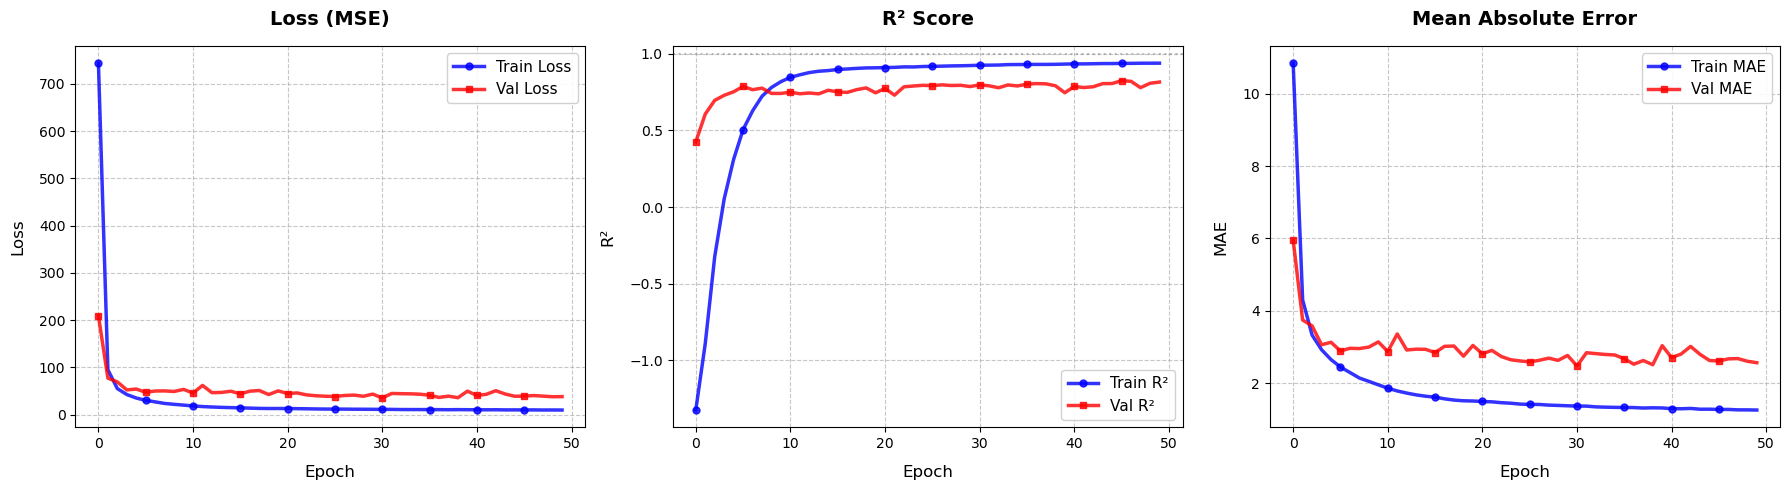

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style

# Create figure with higher DPI for sharpness
plt.figure(figsize=(18, 5), dpi=100)

# --------------------------
# 1. Loss Subplot
# --------------------------
plt.subplot(1, 3, 1)
# Use linewidth and alpha for better visibility
plt.plot(train_losses, label='Train Loss', color='blue', 
         linewidth=2.5, alpha=0.8, marker='o', markersize=5, markevery=5)
plt.plot(val_losses, label='Val Loss', color='red', 
         linewidth=2.5, alpha=0.8, marker='s', markersize=5, markevery=5)

plt.title("Loss (MSE)", fontsize=14, pad=15, fontweight='bold')
plt.xlabel("Epoch", fontsize=12, labelpad=10)
plt.ylabel("Loss", fontsize=12, labelpad=10)

# Add subtle grid
plt.grid(True, linestyle='--', alpha=0.7)
# Customize legend
plt.legend(fontsize=11, loc='upper right', frameon=True, framealpha=0.9)

# --------------------------
# 2. R² Score Subplot
# --------------------------
plt.subplot(1, 3, 2)
plt.plot(train_r2s, label='Train R²', color='blue', 
         linewidth=2.5, alpha=0.8, marker='o', markersize=5, markevery=5)
plt.plot(val_r2s, label='Val R²', color='red', 
         linewidth=2.5, alpha=0.8, marker='s', markersize=5, markevery=5)

plt.title("R² Score", fontsize=14, pad=15, fontweight='bold')
plt.xlabel("Epoch", fontsize=12, labelpad=10)
plt.ylabel("R²", fontsize=12, labelpad=10)

# Add a horizontal line for R=1 (perfect score)
plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11, loc='lower right', frameon=True, framealpha=0.9)

# --------------------------
# 3. MAE Subplot
# --------------------------
plt.subplot(1, 3, 3)
plt.plot(train_maes, label='Train MAE', color='blue', 
         linewidth=2.5, alpha=0.8, marker='o', markersize=5, markevery=5)
plt.plot(val_maes, label='Val MAE', color='red', 
         linewidth=2.5, alpha=0.8, marker='s', markersize=5, markevery=5)

plt.title("Mean Absolute Error", fontsize=14, pad=15, fontweight='bold')
plt.xlabel("Epoch", fontsize=12, labelpad=10)
plt.ylabel("MAE", fontsize=12, labelpad=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11, loc='upper right', frameon=True, framealpha=0.9)

# Improve spacing
plt.tight_layout()

# Save as high-resolution image (optional)
# plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')

plt.show()

## ✅ Step 10: Predicted vs True ΔPollution Plots

C:\Users\User\AppData\Local\Temp\ipykernel_8072\1778508848.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


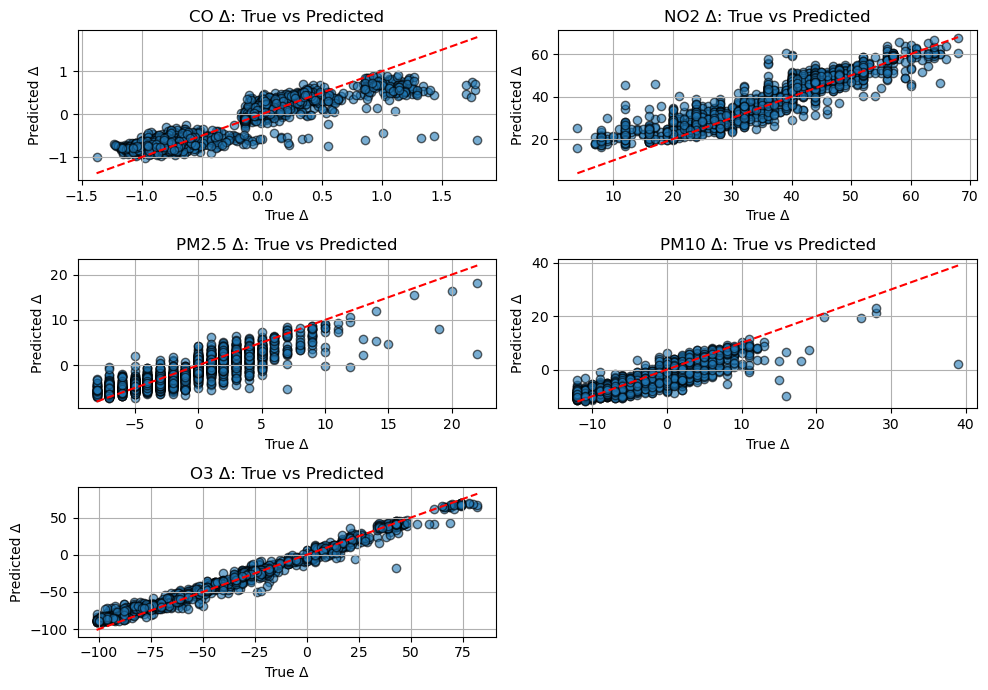

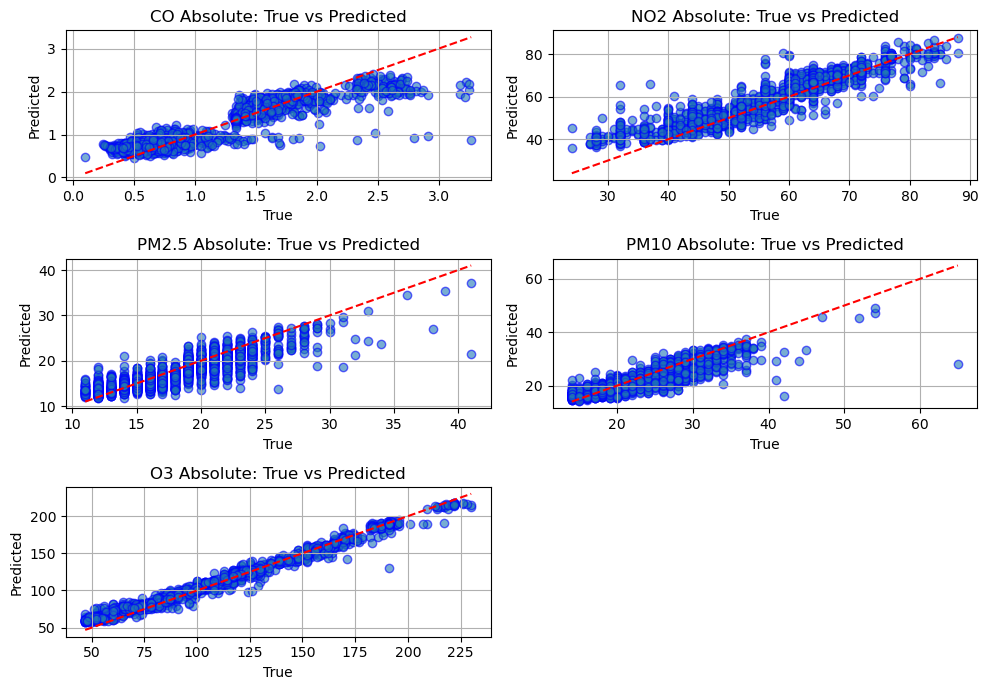

In [13]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

delta_preds, delta_trues, label_b_preds, label_b_trues = [], [], [], []
with torch.no_grad():
    for img_a, img_b, label_a, label_b, delta_y in val_loader:
        img_a, img_b = img_a.to(device), img_b.to(device)
        output = model(img_a, img_b)
        delta_preds.append(output.cpu().numpy())
        delta_trues.append(delta_y.numpy())
        label_b_pred = output + label_a.to(device)
        label_b_preds.append(label_b_pred.cpu().numpy())
        label_b_trues.append(label_b.numpy())
        

preds = np.concatenate(delta_preds)
trues = np.concatenate(delta_trues)
abs_preds = np.concatenate(label_b_preds)
abs_trues = np.concatenate(label_b_trues)

pollutant_names = ['CO', 'NO2', 'PM2.5', 'PM10', 'O3']
plt.figure(figsize=(10, 7))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.scatter(trues[:, i], preds[:, i], alpha=0.6, edgecolor='k')
    plt.plot([trues[:, i].min(), trues[:, i].max()],
             [trues[:, i].min(), trues[:, i].max()], 'r--')
    plt.title(f'{pollutant_names[i]} Δ: True vs Predicted')
    plt.grid()
    plt.xlabel('True Δ')
    plt.ylabel('Predicted Δ')

plt.tight_layout()
plt.show()

pollutant_names = ['CO', 'NO2', 'PM2.5', 'PM10', 'O3']
plt.figure(figsize=(10, 7))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.scatter(abs_trues[:, i], abs_preds[:, i], alpha=0.6, edgecolor='b')
    plt.plot([abs_trues[:, i].min(), abs_trues[:, i].max()],
             [abs_trues[:, i].min(), abs_trues[:, i].max()], 'r--')
    plt.title(f'{pollutant_names[i]} Absolute: True vs Predicted')
    plt.grid()
    plt.xlabel('True')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.show()


## Step 11: Easy Inference with Trained Model

In [19]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from tqdm.auto import tqdm

# ---------- USER INPUTS ----------
proto_image_path = "YauTsingMong/11417_114.168241_22.321326_1707.jpg"   # prototype image path
# proto_label = np.array([0.002, 0.272, 60, 1, 19, 25, 73], dtype=np.float32)  # example; replace with your 7-dim vector
proto_label = np.array([1.4647257, 56.956512, 14.972981, 19.327744, 134.41759], dtype=np.float32)  # example; replace with your 7-dim vector
query_input = "YauTsingMong/"            # EITHER a single image path OR a folder path
output_basename = "YauTsingMong_Contrastive_All_reference11417"              # file prefix for CSV/XLSX when a folder is given
save_excel = True                            # save XLSX in addition to CSV when a folder is given

# ---------- CONSTANTS ----------
# pollutant_names = ['VOC', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10', 'O3']
pollutant_names = ['CO', 'NO2', 'PM2.5', 'PM10', 'O3']
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# ---------- LOAD TRAINED MODEL ----------
# model = PairwiseRegressor(
#     output_dim=5,                # e.g., ['NO2','CO','PM25','PM10','O3']
#     backbone='convnext_tiny',    # or 'resnet50' / 'resnet18'
#     pretrained=True,
#     use_xattn=False,             # global mode
#     use_abs=True,                # concat |Δ| (often helps)
#     se_ratio=8,                  # small channel attention
#     l2norm=True,
#     dropout=0.2
# ).to(device)
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
model.eval()

# ---------- TRANSFORM (same as training) ----------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def _load_image_as_tensor(path: str) -> torch.Tensor:
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

@torch.no_grad()
def predict_single(proto_img_path: str, proto_label_vec: np.ndarray, query_img_path: str) -> np.ndarray:
    """Return predicted Y_B = Y_A + ΔY_pred as numpy vector of shape (7,) with values ≥ 0."""
    proto_tensor = _load_image_as_tensor(proto_img_path)
    query_tensor = _load_image_as_tensor(query_img_path)
    delta_pred = model(proto_tensor, query_tensor)                   # [1, 7]
    y_a = torch.tensor(proto_label_vec, dtype=torch.float32, device=device).unsqueeze(0)  # [1, 7]
    y_b_pred = y_a + delta_pred
    # Clamp values to ensure none are less than 0
    y_b_pred_clamped = torch.clamp(y_b_pred, min=0.0)  # Keep values ≥ 0
    return y_b_pred_clamped.squeeze(0).cpu().numpy()


def _gather_images(folder: str):
    p = Path(folder)
    files = [str(fp) for fp in sorted(p.iterdir()) if fp.is_file() and fp.suffix.lower() in valid_exts]
    return files

def _save_predictions(df: pd.DataFrame, base: str):
    csv_path = f"{base}.csv"
    xlsx_path = f"{base}.xlsx"
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    if save_excel:
        df.to_excel(xlsx_path, index=False)
    print(f"\nSaved: {csv_path}")
    if save_excel:
        print(f"Saved: {xlsx_path}")

# ---------- RUN ----------
query_path = Path(query_input)

if query_path.is_file():
    # Single image mode
    yb = predict_single(proto_image_path, proto_label, str(query_path))
    # Print prototype label with pollutant names
    print("Prototype label (Y_A):")
    for name, value in zip(pollutant_names, proto_label):
        print(f"  {name}: {value:.3f}")  # Format to 2 decimals
    # Print predicted query label with pollutant names
    print("\nPredicted Query label (Y_B):")
    for name, value in zip(pollutant_names, yb):
        print(f"  {name}: {round(value, 2):.3f}")  # Ensure 2 decimal places
elif query_path.is_dir():
    # Folder mode
    image_list = _gather_images(str(query_path))
    if not image_list:
        raise ValueError(f"No valid images found in folder: {query_input}")

    rows = []
    for img_path in tqdm(image_list):
        try:
            yb = predict_single(proto_image_path, proto_label, img_path)
            row = {"Filename": os.path.basename(img_path)}
            row.update({pollutant_names[i]: float(yb[i]) for i in range(5)})
            rows.append(row)
        except Exception as e:
            print(f"⚠️ Skipped {img_path}: {e}")

    df_pred = pd.DataFrame(rows, columns=["Filename"] + pollutant_names)
    print("\nPreview of predictions (first 10 rows):")
    print(df_pred.head(10))
    _save_predictions(df_pred, output_basename)
else:
    raise FileNotFoundError(f"query_input not found: {query_input}")


  0%|          | 0/15313 [00:00<?, ?it/s]


Preview of predictions (first 10 rows):
                              Filename        CO        NO2      PM2.5  \
0       0_114.155583_22.32122_1708.jpg  0.772676  74.820015  12.033301   
1  10000_114.162297_22.322854_1707.jpg  1.056972  68.496880  10.796150   
2  10001_114.162389_22.322789_1707.jpg  1.074100  71.662094  11.735060   
3   10002_114.16245_22.322744_1707.jpg  0.803231  69.243752  11.009331   
4  10003_114.162547_22.322672_1707.jpg  0.863430  73.956345  11.599277   
5  10004_114.162618_22.322616_1707.jpg  1.127496  76.349304  11.039301   
6  10005_114.170731_22.303207_1403.jpg  0.840128  67.065536  12.394739   
7  10006_114.174095_22.307108_1707.jpg  0.921494  64.075249  14.378106   
8  10007_114.169774_22.312886_1707.jpg  1.035215  82.212929  12.508065   
9  10008_114.169875_22.312902_1707.jpg  1.426207  93.252884  15.535754   

        PM10          O3  
0  14.047503  100.514008  
1  13.018724  107.721657  
2  14.342623  102.716324  
3  12.936361  101.272003  
4  13.576